Storage Folder for videos


In [1]:
output_folder = "/mnt/Personal/Projects/Micromouse/Raiden/Playground"

Imported Libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import random
from tqdm import tqdm
from IPython.display import clear_output
from collections import deque
import copy

Experimentable Functions


In [3]:

def get_speed_from_slip_angle(speed,angle):
    return speed

def get_gyro_angle(angle):
    return angle
    # return angle

def get_center_movement(travel_dist):
    return travel_dist

def get_slip_angle_from_speed(speed):
    return np.rad2deg(4)

Map Matrix Initializations


In [4]:
import numpy as np

# for 0 means no other point 1 to 8, the extreme north elemnt is 1, now go clockwise to count
# for 0 to 3, 0 is the path, 1 is the left bound, 2 is the right bound, 3 is default

# (<wheter the point exists>, <previous point direction>, <next point direction>, <which type of line>)

class MapMatrix:
    def __init__(self, n):
        self.size = n
        self.shape = (self.size, self.size)
        self.dtype = np.dtype([
            ('flag', np.bool_),     # Boolean: True/False
            ('prev', np.uint16),    # Direction: 1–8 (N = 0, clockwise)
            ('succ', np.uint16),    # Direction: 1–8 (N = 0, clockwise)
            # Type: 0 = path, 1 = left bound, 2 = right bound, 3 = default
            ('line_type', np.uint8)
        ])
        default_value = np.array((False, 0, 0, 3), dtype=self.dtype)
        self.map_matrix = np.full(self.shape, default_value, dtype=self.dtype)
        self.origin = (0, 0)

        self.upper_origin = (0, 9)
        self.path_origin = (0, 6)
        self.lower_origin = (0, 3)

    def set_value(self, x, y, flag, prev, succ, line_type):
        """Set the value at position (x, y)."""
        if 0 <= x < self.shape[0] and 0 <= y < self.shape[1]:
            self.map_matrix[x][y] = (flag, prev, succ, line_type)
        else:
            raise IndexError("Coordinates out of bounds")

    def get_value(self, x, y):
        """Get the value at position (x, y)."""
        if 0 <= x < self.shape[0] and 0 <= y < self.shape[1]:
            return self.map_matrix[x][y]
        else:
            # raise IndexError("Coordinates out of bounds")
            return (False, 0, 0, 3)

    def get_existence(self, x, y):
        """Get the value at position (x, y)."""
        if 0 <= x < self.shape[0] and 0 <= y < self.shape[1]:
            return self.map_matrix[x][y][0]
        else:
            # raise IndexError("Coordinates out of bounds")
            return False

    def get_prev(self, x, y):
        """Get the value at position (x, y)."""
        if 0 <= x < self.shape[0] and 0 <= y < self.shape[1]:
            return self.map_matrix[x][y][1]
        else:
            # raise IndexError("Coordinates out of bounds")
            return 0

    def get_next(self, x, y):
        """Get the value at position (x, y)."""
        # print(x,y)
        if 0 <= x < self.shape[0] and 0 <= y < self.shape[1]:
            return self.map_matrix[x][y][2]
        else:
            # raise IndexError("Coordinates out of bounds")
            return 0

    def get_line_type(self, x, y):
        """Get the value at position (x, y)."""
        if 0 <= x < self.shape[0] and 0 <= y < self.shape[1]:
            return self.map_matrix[x][y][3]
        else:
            # raise IndexError("Coordinates out of bounds")
            return 3

    def set_origin(self, x, y):
        """Change the origin."""
        self.origin = (x, y)

    def set_path_origin(self, x, y):
        """Change the origin."""
        self.path_origin = (x, y)

    def set_upper_origin(self, x, y):
        """Change the origin."""
        self.upper_origin = (x, y)

    def set_lower_origin(self, x, y):
        """Change the origin."""
        self.lower_origin = (x, y)

    def get_path_origin(self):
        """Get the current origin."""
        return self.path_origin

    def get_upper_origin(self):
        """Get the current origin."""
        return self.upper_origin

    def get_lower_origin(self):
        """Get the current origin."""
        return self.lower_origin

    def get_origin(self):
        """Get the current origin."""
        return self.origin

    def get_size(self):
        return (self.size, self.size)


map_matrix = MapMatrix(n=180)

Helper Functions

In [5]:
def index_within_bounds(x, y):

    size = map_matrix.get_size()

    is_in = True

    if x < 0 or x >= size[0] or y < 0 or y >= size[1]:
        is_in = False

    return is_in


def index_to_point(i, j, min_dist):

    origin = map_matrix.get_origin()

    i, j = i*min_dist+origin[0], j*min_dist+origin[1]

    return i, j


def point_to_index(x, y, min_dist):

    origin = map_matrix.get_origin()
    # print(origin)

    x, y = (x-origin[0])/min_dist, (y-origin[1])/min_dist

    x, y = int(round(x)), int(round(y))

    return x, y


def round_off_step(x, min_dist):

    step = 1/min_dist

    sign = np.sign(x)
    x = abs(x)

    int_x = int(x)
    frac_x = x-int(x)

    idx = round(frac_x*step)/step

    y = sign*(int_x + idx)

    return y

def normalize_radian(rad):
    return np.sign(rad)*(abs(rad)%(2*np.pi))

Find nearest point using approximation

In [6]:
def find_intersection(pos_x, pos_y, theta, max_look, min_dist, boundary):

    dest_x = pos_x + np.cos(theta) * max_look
    dest_y = pos_y + np.sin(theta) * max_look

    pos_i, pos_j = point_to_index(pos_x, pos_y, min_dist)
    dest_i, dest_j = point_to_index(dest_x, dest_y, min_dist)

    x0, y0, x1, y1 = pos_i, pos_j, dest_i, dest_j
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    dist = max_look
    point = []

    while True:
        
        is_there,dist,point = check_around_point(x0,y0,pos_i,pos_j,max_look,min_dist,boundary)
        
        if is_there:
            break
        
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return dist,point
    
    
def check_around_point(idx,idy,first_x,first_y,max_look,min_dist,boundary):
    
    dist = max_look
    fin = []
    
    box = [(0, 0), (0, 1), (1, 1), (1, 0), (1, -1),
                (0, -1), (-1, -1), (-1, 0), (-1, 1)]

    is_there = False

    for b in box:
        nx = int(idx+b[0])

        ny = int(idy+b[1])

        if not index_within_bounds(nx, ny):
            continue

        # checking its the path line and not the boundaries
        if boundary:
            bool_check = map_matrix.get_existence(nx, ny) and (map_matrix.get_line_type(nx, ny) == 1 or map_matrix.get_line_type(nx, ny)==2) 
        else:
            bool_check = map_matrix.get_existence(nx, ny) and map_matrix.get_line_type(nx, ny) == 0
            
        if bool_check:
            is_there = True
            # print(nx,ny)
            # print(map_matrix.get_line_type(nx,ny))

            fx, fy = index_to_point(nx, ny, min_dist)
            sx, sy = index_to_point(first_x, first_y,min_dist)
            # print(fx,fy,sx,sy)

            temp_dist = np.sqrt((fx-sx)**2 + (fy-sy)**2)
            
            # print("Inside",temp_dist,sx,sy,fx,fy)

            if temp_dist < dist:
                dist = temp_dist
                fin = [fx, fy]
                    
    return is_there,dist,fin

def generate_numbers_float(n, m):
    result = []
    val = 0
    while val < n:
        result.append(round(val, 10))  # round to avoid floating point artifacts
        val += m
    return result

def search_around(x, y, theta, max_look, min_dist,div_angle,rotation):

    angle_partition = generate_numbers_float(360,360/div_angle)
    
    angle_partition = [x+(rotation*10)+theta for x in angle_partition]
    
    small_dist=max_look
    small_point=[]
    
    for angle in angle_partition:
    
        # line = path_to_line_list(x, y, angle, max_look, min_dist)
        # dist, point = check_intersection(line, min_dist, max_look, boundary=False)
        
        dist,point = find_intersection(x,y,angle,max_look,min_dist,boundary=False)
        
        if dist<small_dist:
            small_dist=dist
            small_point=[point[0],point[1]]
            
    return small_dist,small_point
            
    
    

Handling point to line distances effectively


In [7]:


def nearby_points(x, y, angle, max_look, min_dist,div_angle):
    # print("org",x,y)
    dist=-1
    point=[]
    rotation=0
    
    while len(point)==0:
        dist, point = search_around(x, y, angle, max_look, min_dist,div_angle,rotation)
        rotation+=1

    # if dist == max_look:
    #     print("Path Ended")
    #     return dist,x,y,x,y

    near_x, near_y = point[0], point[1]

    # print("near x and y",near_x,near_y)

    elem_array = [(0, 0), (0, 1), (1, 1), (1, 0), (1, -1),
                  (0, -1), (-1, -1), (-1, 0), (-1, 1)]

    nx, ny = point_to_index(near_x, near_y, min_dist)
    # print(x,y,near_x,near_y)

    next_elem = map_matrix.get_next(nx, ny)
    nex, ney = elem_array[next_elem][0], elem_array[next_elem][1]

    dx, dy = nx+nex, ny+ney

    dest_x, dest_y = index_to_point(dx, dy, min_dist)

    dist = np.sqrt((dest_x-x)**2 + (dest_y-y)**2)

    # print("dest x and y",dest_x,dest_y)

    end = False

    if next_elem == 0:
        end = True

    return dist, dest_x, dest_y, end


Getting +- trail of functions


In [8]:
def get_path_list(line_type, min_dist):

    if line_type == 0:
        start = map_matrix.get_path_origin()
    elif line_type == 1:
        start = map_matrix.get_upper_origin()
    else:
        start = map_matrix.get_lower_origin()

    point_list = [start]
    # print("hey",time.time())
    while True:
        # print(point_list)
        elem = point_list[-1]
        # print(len(point_list))
        ex, ey = point_to_index(elem[0], elem[1], min_dist)
        next_elem_pos = map_matrix.get_next(ex, ey)

        elem_array = [(0, 0), (0, 1), (1, 1), (1, 0), (1, -1),
                      (0, -1), (-1, -1), (-1, 0), (-1, 1)]
        nex, ney = elem_array[next_elem_pos][0], elem_array[next_elem_pos][1]

        nx, ny = ex+nex, ey+ney

        if map_matrix.get_existence(nx, ny) and map_matrix.get_line_type(nx, ny) == line_type:
            next_x, next_y = index_to_point(nx, ny, min_dist)
            next_elem = (next_x, next_y)

            if next_elem == elem:
                break
            point_list.append(next_elem)
        else:
            break

    x_list = []
    y_list = []

    for point in point_list:
        x_list.append(point[0])
        y_list.append(point[1])

    return x_list, y_list

Error Calculating Fucntions


In [9]:

def accident_theta(t_accident, curr_time, max_deviation, min_deviation):
    
    if t_accident==0:
        return 0,0
    
    if abs((curr_time) % (t_accident)) <= 0.1 and abs(curr_time) >= 0.01:

        if random.random() < 0.5:
            # Range [-b, -a]
            deviation_deg = random.uniform(-max_deviation, -min_deviation)
        else:
            # Range [a, b]
            deviation_deg = random.uniform(min_deviation, max_deviation)

        deviation_rad = np.deg2rad(deviation_deg)

        return deviation_deg, deviation_rad

    return 0, 0


def get_dist_angle(pos_x, pos_y, theta, max_look, min_dist,div_angle):

    # print("fds",pos_x,pos_y)

    dist, dest_x, dest_y, end = nearby_points(
        pos_x, pos_y, theta, max_look, min_dist,div_angle)

    phi = np.arctan2((dest_y-pos_y), (dest_x-pos_x))

    d_theta = theta-phi

    # print("dist and d_theta",dist,d_theta)

    return (dest_x, dest_y), dist, d_theta, end


def get_boundary_ratio(pos_x, pos_y, theta, max_dist, min_dist):

    bound, point = find_intersection(pos_x,pos_y,theta,max_dist,min_dist,boundary=True)

    if point == []:
        return bound, 1


    ratio = 1-((max_dist-bound)/max_dist)

    return bound, ratio

Plotting Function


In [10]:
def plotter(positions, pos_x, pos_y, y_axis, min_dist, max_trail, x_bound, y_bound, delta_dist, delta_angle, speed, bound, stab_ac):

    fig, ax = plt.subplots(figsize=(18, 8))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Customize axes
    if not y_axis:
        ax.yaxis.set_visible(False)
    else:
        ax.tick_params(axis='y', colors='white')

    ax.tick_params(axis='x', colors='white')

    # plot the ball and its trail

    ball, = ax.plot([], [], 'ro', markersize=10)
    trail, = ax.plot([], [], 'r-', linewidth=1)

    mid_line, = ax.plot([], [], 'b-', linewidth=0.5)
    high_line, = ax.plot([], [], 'g-', linewidth=0.5)
    low_line, = ax.plot([], [], 'g-', linewidth=0.5)

    ax.set_xlim(pos_x - x_bound, pos_x + x_bound)
    ax.set_ylim(pos_y-y_bound, pos_y+y_bound)

    i = len(positions) - 1
    pos_x, pos_y = positions[i]
    xs, ys = zip(*positions[max(0, i-max_trail):i+1])

    ball.set_data([pos_x], [pos_y])
    trail.set_data(xs, ys)

    # plotting the points

    x_vals, y_vals = get_path_list(line_type=0, min_dist=min_dist)
    mid_line.set_data(x_vals, y_vals)

    x_vals, y_vals = get_path_list(line_type=1, min_dist=min_dist)
    high_line.set_data(x_vals, y_vals)

    x_vals, y_vals = get_path_list(line_type=2, min_dist=min_dist)
    low_line.set_data(x_vals, y_vals)
    
    # print(speed)

    ax.text(0.95, 0.95, f"dist = {delta_dist:.3f}, angle = {delta_angle:.3f}, v = {speed:.3f}, bound = {bound:.3f}",
            transform=ax.transAxes, fontsize=12, color='white', ha='right', va='top')

    ax.text(0.05, 0.95, f"Stable = {stab_ac}",
                transform=ax.transAxes, fontsize=12, color='white', ha='left', va='top')

    return fig, ax

PID Class


In [11]:
# PID Controller class
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = 0
        self.prev_error = 0

    def update(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
            
        return output

Simulator Function


In [12]:
def simulate_particle(velocity=10, speed_up_ratio=1.0, t_accident=2.0, delta_time=0.0, start_point=(0, 0), start_angle=0, min_dist=0.1,
                      fps=20, y_axis=True, show_gif=False, x_bound=5, y_bound=5, stab_threshold=0.1, max_trail=500, boundary=25,div_angle=8.0,bound_interval=10):

    fps = fps//speed_up_ratio

    deviation_rad = 0
    deviation_deg = 0
    
    if delta_time==0.0:
        dt = min_dist/velocity
    else:
        dt= delta_time

    frame_wait = 1/(fps)
    frame = 0

    pos_x, pos_y = start_point[0], start_point[1]

    angle = np.deg2rad(start_angle)
    
    max_angle_correction = get_slip_angle_from_speed(velocity)
    pid_angle = PID(Kp=20, Ki=5, Kd=0)

    positions = [(pos_x, pos_y)]

    # counter=0
    
    bound = boundary

    start_time = time.time()

    min_deviation = 30
    max_deviation = 90

    total_time = 0

    stability_achieve = False

    while True:
        
        
        #############
        # Accident
        
        deviation_deg, deviation_rad = accident_theta(
            t_accident, total_time, max_deviation, min_deviation)

        angle += deviation_rad
        if deviation_rad != 0:
            stability_achieve = False
        
        ###############
            
            
        ###############
        # Error Calculation

        pos_x, pos_y = positions[-1][0], positions[-1][1]

        nearest_point, delta_dist, delta_angle, end = get_dist_angle(
            pos_x, pos_y, angle, boundary, min_dist,div_angle)

        if nearest_point == (round_off_step(pos_x, min_dist), round_off_step(pos_y, min_dist)) or end:
            break

        ###############


        ###############
        # Speed Calculation
        
        corr_angle = pid_angle.update(delta_angle, dt) * dt
        corr_angle= normalize_radian(corr_angle)
        if abs(corr_angle)>max_angle_correction:
            corr_angle=np.sign(corr_angle)*max_angle_correction
        
        angle = angle - corr_angle
        speed = get_speed_from_slip_angle(velocity,corr_angle)
        
        if int(round(total_time/dt))%bound_interval == 0:
            bound, ratio = get_boundary_ratio(pos_x, pos_y, angle, boundary, min_dist)
            
            speed = velocity*ratio        
        
        ##################
        
        
        
        ##################
        # Get sensor data
        
        travel_dist = dt*speed
        
        travel_dist=get_center_movement(travel_dist)
        angle = get_gyro_angle(angle)
        
        ###################
        
        
        
        ###################
        # Simulating path

        angle = normalize_radian(angle)
        
        dx = travel_dist * np.cos(angle)
        dy = travel_dist * np.sin(angle)
        pos_x += dx
        pos_y += dy
        positions.append((pos_x, pos_y))

        stability_achieve = abs(delta_dist)<=stab_threshold and abs(delta_angle)<=stab_threshold

        total_time += dt
        
        ##################
        
        
        if total_time-(frame+1)*frame_wait > 0  and show_gif:
            
            # while(True and pos_x>2):
            #     pass
            
            clear_output(wait=True)

            frame += 1
            # print(speed)
            fig, _ = plotter(positions, pos_x, pos_y, y_axis, min_dist, max_trail, x_bound, y_bound,
                             delta_dist, delta_angle, speed, bound, stability_achieve)

            time_passed = time.time() - start_time
            wait = total_time/speed_up_ratio - time_passed

            if (wait > 0):
                time.sleep(wait)

            # fig.show()
            plt.show()
            
            

    print("Final Position - ", pos_x, pos_y, "cm")
    print("Total Time - ", total_time, "s")

Making the map


In [13]:
class PathFunction:
    
    def __init__(self):
        self.operations={}
        
    def add_function(self,function_name,function):
        self.operations[function_name]=function
        
    def remove_function(self,function_name):
        self.operations.pop(function_name)
        
    def get_value(self,function_name,input_tuple):
        return self.operations[function_name](*input_tuple)
    
path_function = PathFunction()

Lambda functions of the paths and boundaries

In [14]:
# constant line
# path_function.add_function("path-0",(lambda x,y : y-6))
# path_function.add_function("path-1",(lambda x,y : y-9))
# path_function.add_function("path-2",(lambda x,y : y-3))

# sin function
path_function.add_function("path-0",(lambda x,y : y-6-np.sin(x)))
path_function.add_function("path-1",(lambda x,y : y-9-np.sin(x)))
path_function.add_function("path-2",(lambda x,y : y-3-np.sin(x)))


# quarter circle
# path_function.add_function("path-0",(lambda x,y : (y-18)**2 + (x)**2 - 81 ))
# path_function.add_function("path-1",(lambda x,y : y-9-np.sin(x)))
# path_function.add_function("path-2",(lambda x,y : y-3-np.sin(x)))


In [15]:


def maker_function(x, y, line_type):

    path_name = "path-"+str(line_type)
    return path_function.get_value(path_name,(x,y))


def direc_flipper(direc):
    direc = direc-1
    direc = (direc+4) % 8
    direc = direc+1

    return direc


def nearest_path_point(x, y, min_dist, line_type):

    elem_array = [(0, 1), (1, 1), (1, 0), (1, -1),
                  (0, -1), (-1, -1), (-1, 0), (-1, 1)]

    i, j = point_to_index(x, y, min_dist)

    direc = 0

    min_value = -1
    min_index = [x,y]

    for k, elem in enumerate(elem_array):

        ei, ej = i+elem[0], j+elem[1]

        if not index_within_bounds(ei, ej):
            continue

        if map_matrix.get_existence(ei, ej):
            continue

        ex, ey = index_to_point(ei, ej, min_dist)

        val = abs(maker_function(ex, ey, line_type))

        # print(val)

        if min_value==-1:
            min_value=val
            direc=k+1
            min_index = [ex, ey]
            
        elif val < min_value:

            min_value = val
            direc = k+1
            min_index = [ex, ey]

    # print(direc,min_index)

    return direc, min_index


def path_maker(min_dist, line_type):

    if line_type == 0:
        point = map_matrix.get_path_origin()
    if line_type == 1:
        point = map_matrix.get_upper_origin()
    if line_type == 2:
        point = map_matrix.get_lower_origin()
    x, y = point[0], point[1]

    direc = 0
    prev_direc = 0
    
    size=map_matrix.get_size()
    size=(size[0]-2,size[1]-2)

    while x>=0 and x < size[0]*min_dist and y>=0 and y < size[1]*min_dist:

        direc, min_index = nearest_path_point(x, y, min_dist, line_type)

        if min_index == []:
            break

        i, j = point_to_index(x, y, min_dist)
        # print(x,y,line_type)
        map_matrix.set_value(i, j, True, prev_direc, direc, line_type)

        x, y = min_index[0], min_index[1]
        prev_direc = direc_flipper(direc)

    i, j = point_to_index(x, y, min_dist)
    map_matrix.set_value(i, j, True, prev_direc, 0, line_type)


def create_paths(min_dist):
    path_maker(min_dist, line_type=0)
    path_maker(min_dist, line_type=1)
    path_maker(min_dist, line_type=2)
    
    

Execution


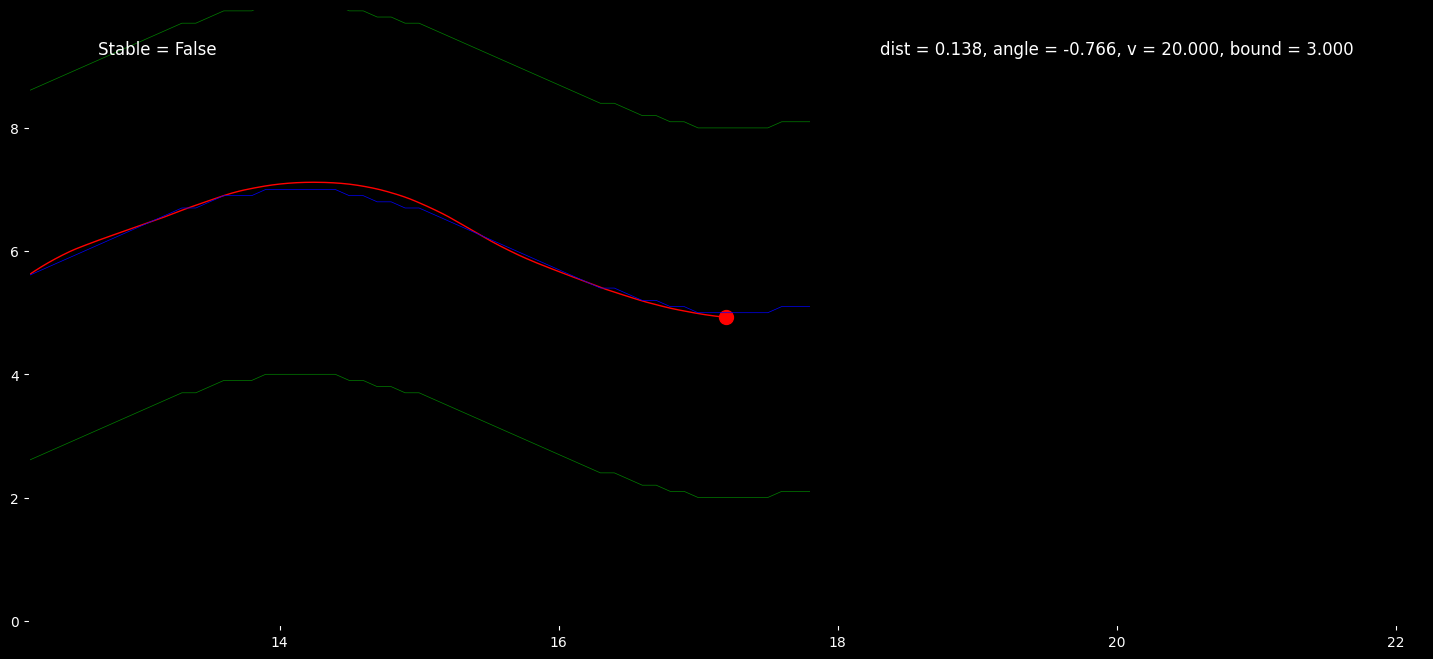

Final Position -  17.752561046631225 4.95802961945438 cm
Total Time -  1.1289999999999865 s


In [16]:

create_paths(min_dist=0.1)

# speed - 600 , speed_up_ratio - 0.01 , t_accident - 0.005 (4 times) ,  fps = 20 ------- works (min dev = 2 , max dev = 6) (straightline)

target_speed = 20

vel = 20

simulate_particle(velocity=vel,
                  speed_up_ratio=target_speed/vel,
                  delta_time=0.001,
                  t_accident=0,
                  div_angle=8,
                  start_point=(0, 6),
                  start_angle=0,
                  min_dist=0.1,
                  fps=20,
                  y_axis=True,
                  show_gif=True,
                  x_bound=5,
                  y_bound=5,
                  stab_threshold=0.2,
                  max_trail=500,
                  boundary=3,
                  bound_interval=10)